### Calibrando umidade
#### Primeiro foi importado os dados com ajuda da biblioteca pandas, assim, criamos uma lista com os dados no horário necessário e outra com os dados certo pegando dados a cada 5, pois antes estavam a cada 1 minuto e é necessário ser a cada 5 minutos.

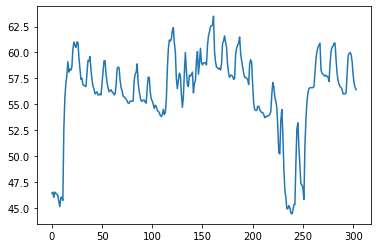

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
dados_datacenter = pd.read_excel('Dados-Guilherme.xlsx')
lista_dados = list(dados_datacenter["Unnamed: 2"][1227:2747])
lista_dados_novos_umidade =[] #lista varia para armarzenar os dados certos
lista_dados_novos_umidade=[lista_dados[i]for i in range(0,len(lista_dados),5)] # pegando dados de 5 em 5
grafico_datacenter = pd.DataFrame(lista_dados_novos_umidade)
plt.plot(grafico_datacenter)
plt.show()

#### Plotamos os dados sem calibrar para entender nosso problema.

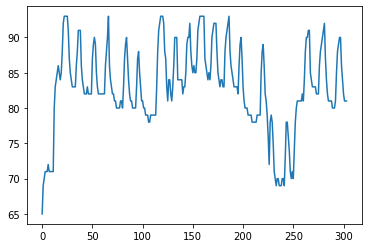

In [14]:
dados_umidade_temperatura = pd.read_csv('feeds.csv',sep=",")
plt.plot(dados_umidade_temperatura["field2"]) #grafico normal
plt.show()

#### Agora para calibrar utilizamos a biblioteca scipy.optimize para fazer uma calibração usando uma função linear, considerando os dados obtidos com o DHT11 como os valores de x e o datacenter como y, com isso podemos aproximar nossos dados com os dados "corretos", após achar o valor de a e b, sendo a função $a+bx$, plotamos o gráfico com os valores calibrados e o correto.

3.6398067467864834 0.6332527238104956


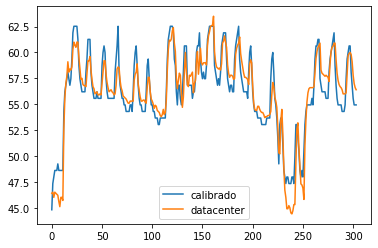

In [15]:
def func_calibração(x, a, b):
    return a + (b*x)

def calibração(para_calibrar,reais):
    a_umidade,b_umidade = encontrar_modelo(list(para_calibrar), reais, func_calibração)
    lista_calibrada_umidade=[func_calibração(i,a_umidade,b_umidade) for i in para_calibrar]
    return(lista_calibrada_umidade,a_umidade,b_umidade)

def encontrar_modelo(x_vals, y_vals, func):
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(func, x_vals, y_vals)
    if len(popt) > 1:
        return list(popt)
    else:
        return popt[0]


lista_calibrada_umidade,a_umidade,b_umidade = calibração(dados_umidade_temperatura["field2"],lista_dados_novos_umidade)
plt.plot(pd.DataFrame(lista_calibrada_umidade), label='calibrado')
plt.plot(grafico_datacenter, label='datacenter')
plt.legend()
# plt.show()
plt.savefig('grafico_calibradoXdatacenter_umidade.png', dpi=500, bbox_inches='tight')
print(a_umidade,b_umidade)

### Calibrando temperatura

### Para a temperatura usamos a mesma lógica expressa anteriormente, somente mudando a base de dados utilizados.

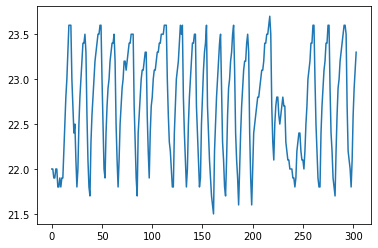

In [16]:
lista_dados = list(dados_datacenter["ILUM - CORREDOR FRIO"][1227:2747])
lista_dados_novos_temperatura=[lista_dados[i] for i in range(0,len(lista_dados),5)]
grafico_datacenter_temperatura = pd.DataFrame(lista_dados_novos_temperatura)
plt.plot(grafico_datacenter_temperatura)
plt.show()

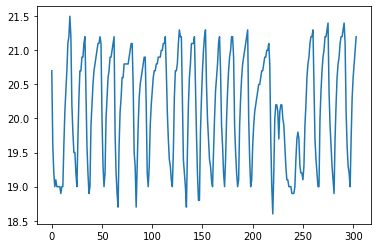

In [17]:
plt.plot(dados_umidade_temperatura["field1"]) #grafico normal
plt.show()

9.355976022706546 0.6627333544331856


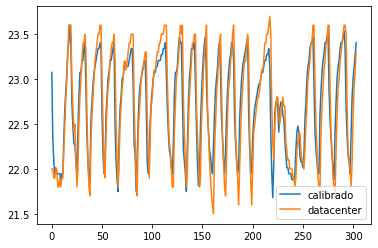

In [18]:
lista_calibrada_temperatura,a_temperatura, b_temperatura =calibração(dados_umidade_temperatura["field1"],lista_dados_novos_temperatura)
plt.plot(pd.DataFrame(lista_calibrada_temperatura), label='calibrado')
plt.plot(grafico_datacenter_temperatura, label='datacenter')
plt.legend()
# plt.show()
plt.savefig('grafico_calibradoXdatacenter_temperatura.png', dpi=500, bbox_inches='tight')
print(a_temperatura, b_temperatura)

#### Com isso, os valores conseguidos foram esses:

In [8]:
print(f"a da temperatura = {a_temperatura} \nb da temperatura = {b_temperatura}\na da umidade = {a_umidade}\nb da umidade = {b_umidade}")

a da temperatura = 9.355976022706546 
b da temperatura = 0.6627333544331856
a da umidade = 3.6398067467864834
b da umidade = 0.6332527238104956


#### Agora, calcularemos o RMSE (Root Mean Squared Error - Raiz Quadrada do Erro Médio) com a biblioteca Numpy para a curva não calibrada e para a calibrada usando a fórmula:
$$\displaystyle \sqrt{{1 \over n} \sum_{i=1}^{n} (y_i-y)^2}$$

#### Para isso transformaremos cada dado em um array, sendo basicamente uma lista que o Numpy usa, após transformados colocamos na função para assim calcular o RMSE.

In [9]:
import numpy as np
import math
array_datacenter_temperatura = np.array(lista_dados_novos_temperatura)
array_datacenter_umidade= np.array(lista_dados_novos_umidade)

array_umidade = np.array(list(dados_umidade_temperatura["field2"]))
array_temperatura = np.array(list(dados_umidade_temperatura["field1"]))

array_umidade_calibrada = np.array(lista_calibrada_umidade)
array_temperatura_calibrada = np.array(lista_calibrada_temperatura)

# Agora podemos usar as listas definidas para fazer a função.
rmse_umidade = math.sqrt(np.square(np.subtract(array_datacenter_umidade, array_umidade)).mean())
rmse_temperatura = math.sqrt(np.square(np.subtract(array_datacenter_temperatura, array_temperatura)).mean())

rmse_umidade_calibrada = math.sqrt(np.square(np.subtract(array_datacenter_umidade, array_umidade_calibrada)).mean())
rmse_temperatura_calibrada = math.sqrt(np.square(np.subtract(array_datacenter_temperatura, array_temperatura_calibrada)).mean())

#### Com isso conseguimos os seguintes dados, percebemos que comparado com os dados anteriores a calibração foi eficiente.

In [10]:
print(f"Rmse da umidade sem calibrar: {rmse_umidade}\nRmse da temperatura sem calibrar: {rmse_temperatura}\nRmse da umidade calibrada: {rmse_umidade_calibrada}\nRmse da temperatura calibrada: {rmse_temperatura_calibrada}")

Rmse da umidade sem calibrar: 26.939712175620272
Rmse da temperatura sem calibrar: 2.583048229881652
Rmse da umidade calibrada: 1.493886083006758
Rmse da temperatura calibrada: 0.28204748672585755
